<div style="background-color:#173267;text-align:center;font-family:Arial;color:white;">
    <br>
    <img src="Files/logo-uc-01.svg" style="width:20%;margin:10px">
    <p style="font-size:40pt;font-weight:bold;text-align:center">
        AYUDANTÍA 12: Regresión Logística/KNN/Decision Trees
    </p>
    <p style="font-size:20pt;font-weight:bold;margin:20px;text-align:center">
        Introducción a la Ciencia de Datos
    </p>
    <p style="font-size:12pt;text-align:center">
        Felipe Gutiérrez - figutier@uc.cl
        Nicolas Mendicoa - nmendicoa@uc.cl
        <br>8 de noviembre de 2022
    </p>
    <p style="text-align:center;font-family:Trebuchet MS;color:white;font-size:12pt;">        
        Basado en notebook de:
        Vicente Agüero - vicenteaguero@uc.cl
        <br>
    </p>
    <br><br>
</div>

In [52]:
from sklearn import metrics, model_selection, linear_model, preprocessing, tree, ensemble, datasets
from sklearn.neighbors import KNeighborsRegressor
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
import re
from sklearn.metrics import f1_score, fbeta_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import uniform
from sklearn import tree

# Regresión Logística
Modela la probabilidad de un evento $P(Y=1)$ en función de uno o más predictores $X_i$. Usaremos el modelo de regresion logistica para clasificar. Primero veamos el caso en que $Y$ es binario (toma valores 0 o 1)

<div style="text-align:center;">
    <img src="https://miro.medium.com/max/413/1*-a_J9I0cr0BoJRc_6MhJog.png" style="width:30%;"/><br>
</div>

La funcion logistica se define como:
$$\sigma(t) = \frac{1}{1+e^{-t}}$$
En el contexto de regresion logistica, podemos modelar $t$ en funcion de $x$. Es decir $t(x) = \beta_0 + \beta_1 x$ (es una regresion lineal!). Luego tendremos 
$$ \sigma(t) = p(x) = \frac{1}{1+e^{-(\beta_0 + \beta_1 x)}}$$
Entonces $p(x)$ modela la probabilidad de que la variable binaria $y$ tome valor 1/True dado $x$. Una vez hecho esto, clasificaremos segun esta probabilidad.

Si tenemos varias clases para $Y$, calculamos la probabilidad para cada clase individualmente (binariamente) y nos quedamos con aquella más probable.

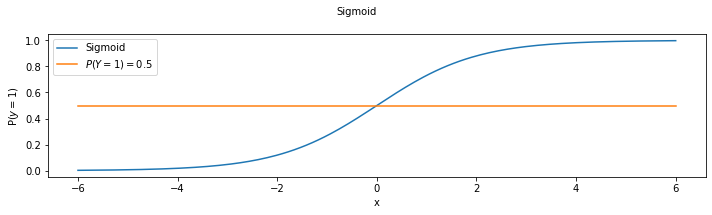

In [2]:
sigmoid = lambda t: 1/(1+np.exp(-t))
t = np.linspace(-6, 6, num=200)
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(t, sigmoid(t),label='Sigmoid')
ax.plot([-6, 6], [0.5, 0.5],label='$P(Y=1)=0.5$')
ax.set_xlabel('x')
ax.legend()
ax.set_ylabel(r'$\mathrm{P}(y=1)$')
fig.suptitle('Sigmoid', size=10)
fig.tight_layout()
plt.show()

In [162]:
#https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset
cardio = pd.read_csv('Files/cardio.csv',delimiter=";")
cardio.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [163]:
cardio['age'] = cardio['age'].apply(lambda x: 0.002738*x)

In [7]:
cardio.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50.360034,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55.384264,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51.630466,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48.251774,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47.843812,1,156,56.0,100,60,1,1,0,0,0,0


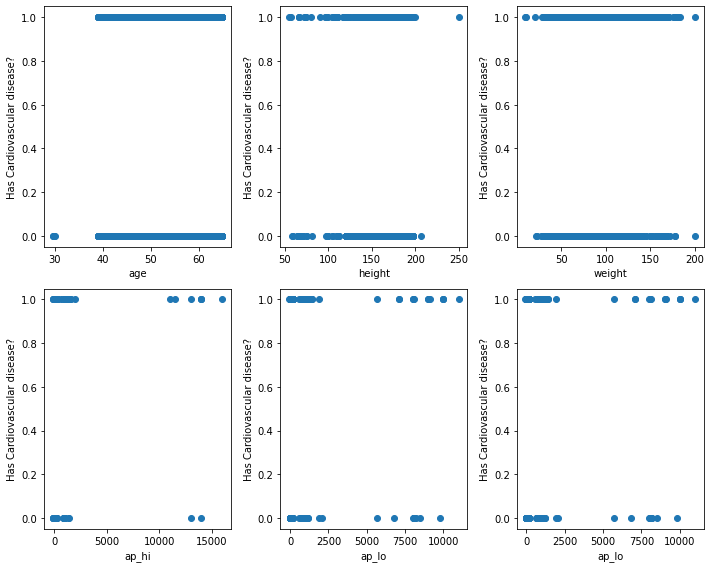

In [9]:
sc = {(0,0): 'age', (0,1): 'height', (0,2): 'weight', (1,0): 'ap_hi', (1,1): 'ap_lo', (1,2): 'ap_lo'}
fig, ax = plt.subplots(2, 3, figsize=(10, 8))
for i in range(2):
    for j in range(3):
        ax[i][j].scatter(sc[(i,j)], 'cardio', data=cardio)
        ax[i][j].set(xlabel=sc[(i,j)], ylabel="Has Cardiovascular disease?")
plt.tight_layout()

In [8]:
cardio.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [9]:
cardio['cardio'].value_counts()

0    35021
1    34979
Name: cardio, dtype: int64

In [164]:
X = cardio[['age','gender','height','weight','ap_hi','ap_lo','cholesterol','gluc','smoke','alco','active']]
y = cardio['cardio']

In [165]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
X_train.shape

(49000, 11)

In [16]:
logreg = linear_model.LogisticRegression(max_iter=3000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

# Metricas de clasificacion

<div style="text-align:center;">
    <img src="https://miro.medium.com/max/1400/0*JpiWBlOFqYTPa8Ta.png" style="width:50%;"/><br>
</div>

* Accuracy: De todas las predicciones, cuales acertaron? (diagonal en imagen anterior)
$$\texttt{Accuracy}= \frac{TP+TN}{Total}$$
* Precision: De todas las predicciones positivas, cuales acertaron? (primera fila en imagen anterior)
$$\texttt{Precision}= \frac{TP}{TP+FP}$$
* Recall: De todas los valores reales positivos, cuales acertaron la prediccion? (primera columna en imagen anterior)
$$\texttt{Recall}= \frac{TP}{TP+FN}$$
* $F_1$-Score: Buscamos balancear precision y recall
$$\texttt{F1-Score}= 2\frac{Precision \cdot Recall}{Precision + Recall}$$
* $F_{\beta}$-Score: Generalizacion de $F_1$-Score, elegimos $\beta$ tal que el $Recall$ se considere $\beta$ veces mas importante que la precision
$$\texttt{$F_{\beta}$-Score}= (1+\beta^2) \cdot \frac{Precision \cdot Recall}{(\beta^2 \cdot Precision) + Recall}$$

In [28]:
predicted = logreg.predict(X_test)
expected = y_test
print(metrics.classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.70      0.76      0.73     10461
           1       0.74      0.68      0.71     10539

    accuracy                           0.72     21000
   macro avg       0.72      0.72      0.72     21000
weighted avg       0.72      0.72      0.72     21000



In [39]:
print(f'F1, class 0:  {fbeta_score(expected==0, predicted==0, beta=1):.2f}')
print(f'F1, class 1:  {fbeta_score(expected==1, predicted==1, beta=1):.2f}\n')

print(f'F2, class 0:  {fbeta_score(expected==0, predicted==0, beta=2):.2f}')
print(f'F2, class 1:  {fbeta_score(expected==1, predicted==1, beta=2):.2f}\n')

print(f'F0.5, class 0:  {fbeta_score(expected==0, predicted==0, beta=0.5):.2f}')
print(f'F0.5, class 1:  {fbeta_score(expected==1, predicted==1, beta=0.5):.2f}')

F1, class 0:  0.73
F1, class 1:  0.71

F2, class 0:  0.75
F2, class 1:  0.69

F0.5, class 0:  0.71
F0.5, class 1:  0.73


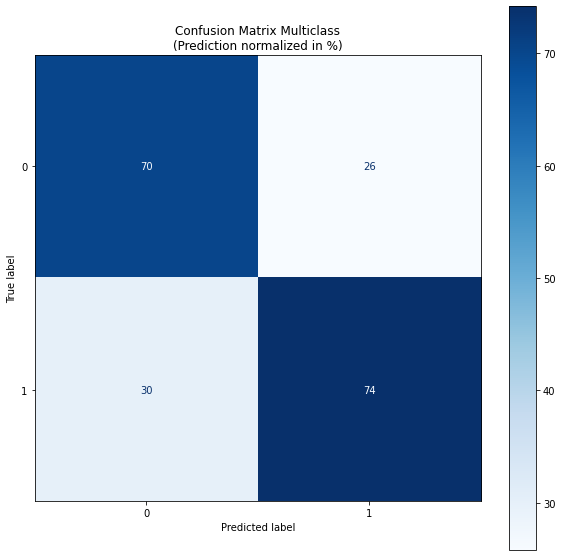

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cm = ConfusionMatrixDisplay((confusion_matrix(expected, predicted)/np.unique(predicted, return_counts=True)[1])*100).plot(ax=ax, cmap='Blues')
ax.set_title('Confusion Matrix Multiclass\n(Prediction normalized in %)')
plt.show()

In [19]:
logreg.classes_

array([0, 1], dtype=int64)

In [23]:
# Tambien podemos predecir la probabilidad
logreg.predict_proba(X_test[:10]).round(3)

array([[0.257, 0.743],
       [0.186, 0.814],
       [0.302, 0.698],
       [0.496, 0.504],
       [0.662, 0.338],
       [0.576, 0.424],
       [0.758, 0.242],
       [0.523, 0.477],
       [0.068, 0.932],
       [0.223, 0.777]])

In [24]:
y_test[:10]

46730    1
48393    1
41416    1
34506    1
43725    0
11615    0
24656    0
22411    1
936      1
56364    0
Name: cardio, dtype: int64

In [19]:
# intentemos encontrar buenos hiperparametros

# GridSearchCV se demora mucho para esto, no se los recomiendo, a menos que bajen la tolerancia
# logreg = linear_model.LogisticRegression(max_iter=1000)
# params_grid = {'C':[0.01, 0.1, 1, 10, 100],
#                'penalty': ['l1', 'l2'],
#                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
# gridcv = model_selection.GridSearchCV(logreg, params_grid, cv=5, verbose=3, n_jobs=-1)
#gridcv.fit(X_train, y_train)


In [8]:
logreg = linear_model.LogisticRegression(solver='saga', tol=1e-2, max_iter=200)
distributions = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'])
clf = model_selection.RandomizedSearchCV(logreg, distributions, random_state=0)

In [9]:
clf.fit(X_train, y_train)

RandomizedSearchCV(estimator=LogisticRegression(max_iter=200, solver='saga',
                                                tol=0.01),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000266020CFF40>,
                                        'penalty': ['l2', 'l1']},
                   random_state=0)

In [10]:
predicted = clf.predict(X_test)
expected = y_test
print(metrics.classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.68      0.76      0.72     10461
           1       0.73      0.65      0.69     10539

    accuracy                           0.71     21000
   macro avg       0.71      0.71      0.70     21000
weighted avg       0.71      0.71      0.70     21000



# Decision Trees

<div style="text-align:center;">
    <img src="https://help.sap.com/doc/7b783465728810148a4b1a83b0e91070/1511%20002/de-DE/loiod486240f89a849a2bf9ed8622553b6a9_LowRes.png" style="width:50%;"/>
</div>

In [166]:
treeclf = tree.DecisionTreeClassifier()
treeclf = treeclf.fit(X_train, y_train)

In [168]:
y_test[:10]

46730    1
48393    1
41416    1
34506    1
43725    0
11615    0
24656    0
22411    1
936      1
56364    0
Name: cardio, dtype: int64

In [68]:
treeclf.predict(X_test[:10])

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1], dtype=int64)

In [69]:
treeclf.predict_proba(X_test[:10])

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]])

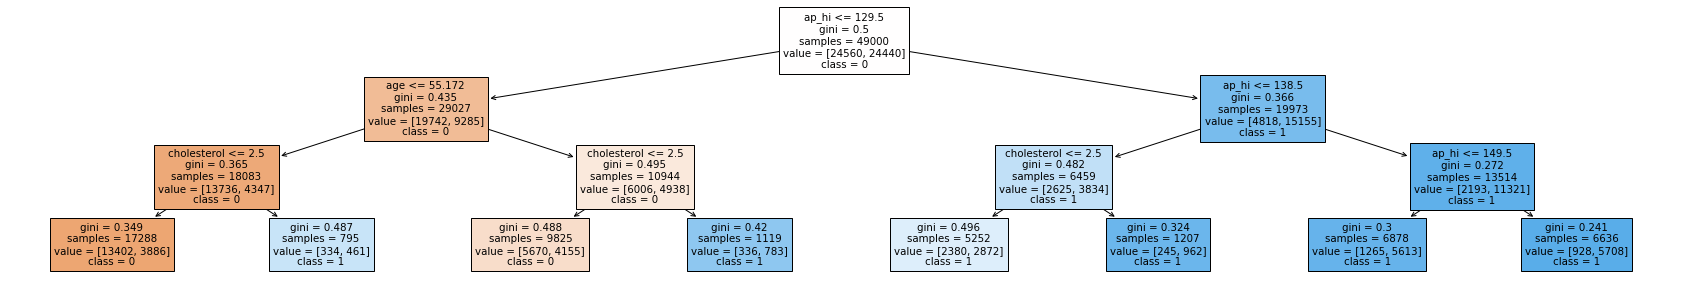

In [186]:
treeclf = tree.DecisionTreeClassifier(max_depth=3)
treeclf = treeclf.fit(X_train, y_train)

fig = plt.figure(figsize=(30, 5))
#tree.plot_tree(treeclf)
tree.plot_tree(treeclf, feature_names=treeclf.feature_names_in_,
                   class_names=[str(i) for i in treeclf.classes_], filled=True)
plt.show()

In [187]:
treeclf.feature_names_in_

array(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active'], dtype=object)

# Tambien podemos clasificar con multiples clases

In [137]:
# https://www.kaggle.com/datasets/ishantjuyal/emotions-in-text
emotions = pd.read_csv('Files/emotions.csv')
emotions.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


### Queremos convertir los mensajes de texto en vectores
Hay varias maneras de hacer esto, con vectores de ocurrencia, word embeddings, etc

In [132]:
emotions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21459 non-null  object
 1   Emotion  21459 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB


In [138]:
# Pasamos a minuscula
emotions['Text'] = emotions['Text'].str.lower()
# Quitamos caracteres especiales
emotions['Text'] = emotions['Text'].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', '', x))

In [139]:
from sklearn.feature_extraction.text import CountVectorizer

# Convertimos frase a vector de palabras
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(emotions['Text'])

y = emotions['Emotion']
X.shape

(21459, 19282)

In [140]:
emotions['Emotion'].value_counts()

happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: Emotion, dtype: int64

# Ejercicio 1
Hacer el mismo procedimiento con word embeddings en vez de vector de ocurrencias. Mejora el resultado?

In [141]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

In [143]:
def DecisionTree(X, y, class_column, test_size):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, random_state=0,
                                                                        test_size=test_size)
    treeclf = tree.DecisionTreeClassifier()
    treeclf = treeclf.fit(X_train, y_train)
    predicted = treeclf.predict(X_test)
    expected = y_test
    time.sleep(1)
    print(treeclf.score(X_train, y_train))
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    metrics.ConfusionMatrixDisplay.from_predictions(expected, predicted, ax=ax, cmap='Blues')
    ax.set_title('Confusion Matrix Multiclass')
    plt.show()
    return metrics.classification_report(expected, predicted)

0.9982690899407496


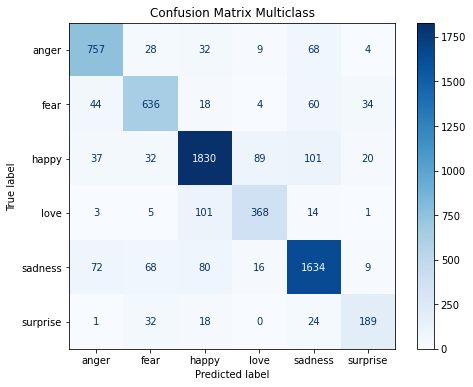

              precision    recall  f1-score   support

       anger       0.83      0.84      0.84       898
        fear       0.79      0.80      0.80       796
       happy       0.88      0.87      0.87      2109
        love       0.76      0.75      0.75       492
     sadness       0.86      0.87      0.86      1879
    surprise       0.74      0.72      0.73       264

    accuracy                           0.84      6438
   macro avg       0.81      0.81      0.81      6438
weighted avg       0.84      0.84      0.84      6438



In [144]:
print(DecisionTree(X, y, 'Emotion', 0.3))

In [145]:
def logistic_regression(X, y, class_column, test_size, **lr_kwargs):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, random_state=0,
                                                                        test_size=test_size)
    lr = linear_model.LogisticRegression(random_state=0, n_jobs=-1, max_iter=2000, **lr_kwargs)
    lr.fit(X_train, y_train)
    predicted = lr.predict(X_test)
    expected = y_test
    time.sleep(1)
    print(lr.score(X_train, y_train))
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    metrics.ConfusionMatrixDisplay.from_predictions(expected, predicted, ax=ax, cmap='Blues')
    ax.set_title('Confusion Matrix Multiclass')
    plt.show()
    return metrics.classification_report(expected, predicted)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   25.6s finished


0.987617335729978


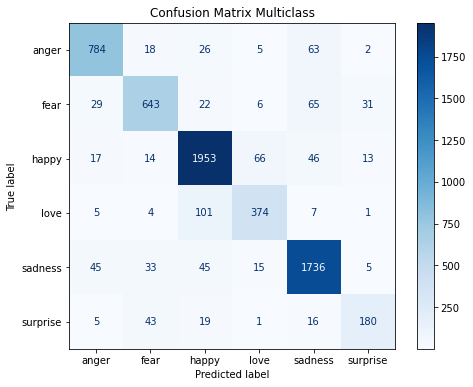

              precision    recall  f1-score   support

       anger       0.89      0.87      0.88       898
        fear       0.85      0.81      0.83       796
       happy       0.90      0.93      0.91      2109
        love       0.80      0.76      0.78       492
     sadness       0.90      0.92      0.91      1879
    surprise       0.78      0.68      0.73       264

    accuracy                           0.88      6438
   macro avg       0.85      0.83      0.84      6438
weighted avg       0.88      0.88      0.88      6438



In [146]:
print(logistic_regression(X, y, 'Emotion', 0.3, verbose=3))

In [ ]:
# Bastante poco balanceado
y.value_counts()

happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: Emotion, dtype: int64

In [147]:
# Podriamos querer balancear y ver si mejora el desempeño
vc = emotions['Emotion'].value_counts()
vc
emotions = emotions[emotions['Emotion'].isin(vc.index[:7])]
emotions = emotions.groupby('Emotion', group_keys=False).apply(lambda x: x.sample(min(len(x), 879)))
emotions.reset_index(drop=True, inplace=True)

In [150]:
X2 = vectorizer.fit_transform(emotions['Text'])

y2 = emotions['Emotion']
X2.shape

(5274, 9197)

In [151]:
emotions['Emotion'].value_counts()

love        879
sadness     879
fear        879
surprise    879
happy       879
anger       879
Name: Emotion, dtype: int64

0.999729070712544


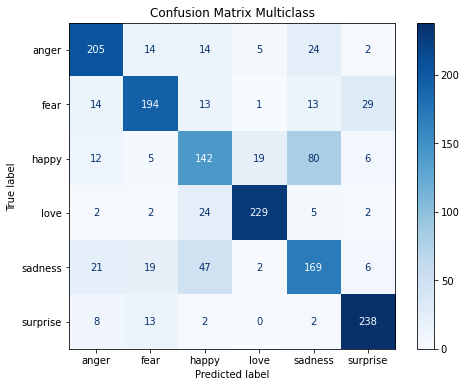

              precision    recall  f1-score   support

       anger       0.78      0.78      0.78       264
        fear       0.79      0.73      0.76       264
       happy       0.59      0.54      0.56       264
        love       0.89      0.87      0.88       264
     sadness       0.58      0.64      0.61       264
    surprise       0.84      0.90      0.87       263

    accuracy                           0.74      1583
   macro avg       0.74      0.74      0.74      1583
weighted avg       0.74      0.74      0.74      1583



In [153]:
print(DecisionTree(X2, y2, 'Emotion', 0.3))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.2s finished


0.9951232728257925


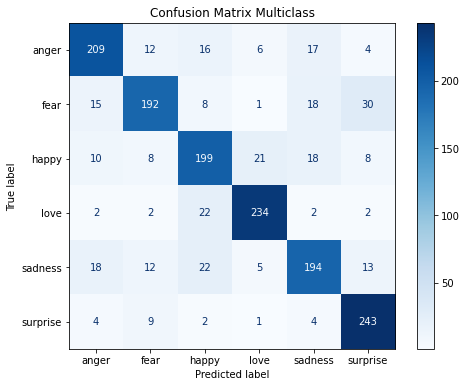

              precision    recall  f1-score   support

       anger       0.81      0.79      0.80       264
        fear       0.82      0.73      0.77       264
       happy       0.74      0.75      0.75       264
        love       0.87      0.89      0.88       264
     sadness       0.77      0.73      0.75       264
    surprise       0.81      0.92      0.86       263

    accuracy                           0.80      1583
   macro avg       0.80      0.80      0.80      1583
weighted avg       0.80      0.80      0.80      1583



In [154]:
print(logistic_regression(X2, y2, 'Emotion', 0.3, verbose=3))

In [156]:
treeclf = tree.DecisionTreeClassifier(max_depth=3)
treeclf = treeclf.fit(X_train, y_train)

# Regresión KNN
Predecimos el target interpolando los targets de los k vecinos mas cercanos

In [188]:
car = pd.read_csv('Files/car.csv')
car.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [193]:
X = car[['enginesize', 'wheelbase']]
y = car['price']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

In [194]:
X_train.shape

(143, 2)

In [195]:
neigh = KNeighborsRegressor(n_neighbors=2)
neigh = neigh.fit(X_train, y_train)

In [202]:
predicted = neigh.predict(X_test)
expected = y_test

metrics.r2_score(predicted, expected)

0.807896442680506